In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm
from random import randint

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
ENCODING_DIMENSION = 32
BATCH_SIZE = 256
EPOCHS = 100

In [4]:
def load_data():
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train / 255.
    x_train = x_train.reshape((x_train.shape[0], np.prod(x_train.shape[1:])))
    x_test = x_test / 255.
    x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))
    return x_train, x_test

In [5]:
x_train, x_test = load_data()
x_train.shape, x_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 784), (10000, 784))

In [6]:
def build_autoencoder(image_width, image_height, encoding_dimension):
    image_shape = image_width * image_height
    
    input_placeholder = Input(shape = (image_shape, ))
    
    # Encoding
    encoded = Dense(encoding_dimension * 4, activation = 'relu', name = 'Encoding_Layer_1')(input_placeholder)
    encoded = Dense(encoding_dimension * 2, activation = 'relu', name = 'Encoding_Layer_2')(encoded)
    encoded = Dense(encoding_dimension, activation = 'relu', name = 'Encoding_Layer_3')(encoded) 
    
    # Decoding
    decoded = Dense(encoding_dimension * 2, activation = 'relu', name = 'Decoding_Layer_1')(encoded)
    decoded = Dense(encoding_dimension * 4, activation = 'relu', name = 'Decoding_Layer_2')(decoded)
    decoded = Dense(image_width * image_height, activation = 'sigmoid', name = 'Decoding_Layer_3')(decoded)
    
    # Encoder
    encoder = Model(input_placeholder, encoded, name = 'Encoder')
    
    # Autoencoder
    autoencoder = Model(input_placeholder, decoded, name = 'Autoencoder')
    
    # Decoder
    encoded_input = Input(shape = (encoding_dimension, ))
    decoder_layer_1 = autoencoder.layers[-3]
    decoder_layer_2 = autoencoder.layers[-2]
    decoder_layer_3 = autoencoder.layers[-1]
    decoder = decoder_layer_1(encoded_input)
    decoder = decoder_layer_2(decoder)
    decoder = decoder_layer_3(decoder)
    final_decoder = Model(encoded_input, decoder, name = 'Decoder')
    
    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    
    return encoder, final_decoder, autoencoder

In [7]:
encoder, decoder, autoencoder = build_autoencoder(IMAGE_WIDTH, IMAGE_HEIGHT, ENCODING_DIMENSION)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Encoding_Layer_1 (Dense)     (None, 128)               100480    
_________________________________________________________________
Encoding_Layer_2 (Dense)     (None, 64)                8256      
_________________________________________________________________
Encoding_Layer_3 (Dense)     (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


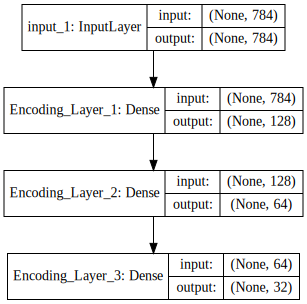

In [9]:
SVG(model_to_dot(encoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
Decoding_Layer_1 (Dense)     (None, 64)                2112      
_________________________________________________________________
Decoding_Layer_2 (Dense)     (None, 128)               8320      
_________________________________________________________________
Decoding_Layer_3 (Dense)     (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


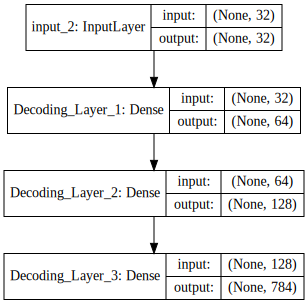

In [11]:
SVG(model_to_dot(decoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Encoding_Layer_1 (Dense)     (None, 128)               100480    
_________________________________________________________________
Encoding_Layer_2 (Dense)     (None, 64)                8256      
_________________________________________________________________
Encoding_Layer_3 (Dense)     (None, 32)                2080      
_________________________________________________________________
Decoding_Layer_1 (Dense)     (None, 64)                2112      
_________________________________________________________________
Decoding_Layer_2 (Dense)     (None, 128)               8320      
_________________________________________________________________
Decoding_Layer_3 (Dense)     (None, 784)               101136    
Total para

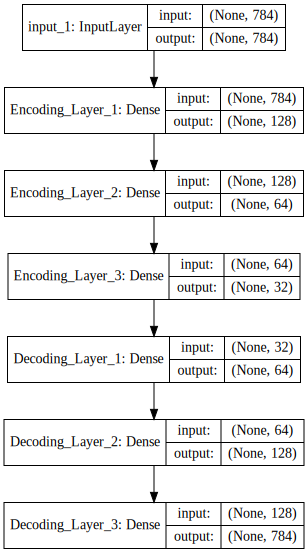

In [13]:
SVG(model_to_dot(autoencoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [14]:
history = autoencoder.fit(x_train, x_train, epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 5s 82us/sample - loss: 0.3497 - val_loss: 0.2638
Epoch 2/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2575 - val_loss: 0.2500
Epoch 3/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2383 - val_loss: 0.2276
Epoch 4/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2230 - val_loss: 0.2151
Epoch 5/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2098 - val_loss: 0.2043
Epoch 6/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1993 - val_loss: 0.1942
Epoch 7/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1884 - val_loss: 0.1813
Epoch 8/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1801 - val_loss: 0.1758
Epoch 9/100
60000/60000 [=============

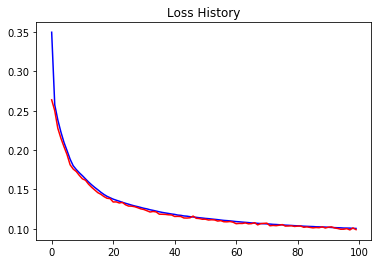

In [15]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.title('Loss History')
plt.show()

In [16]:
def plot_images(nrows, figsize, image_width, image_height, encoder, decoder):
    ncols = 3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    index = randint(0, len(x_test) - 1)
    encoded_image = None
    for i, ax in enumerate(axes.flat):
        if i % 3 == 0:
            index = randint(0, len(x_test) - 1)
            ax.imshow(x_test[index].reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Test_Image_' + str(index))
        elif i % 3 == 1:
            encoded_image = encoder.predict(x_test[index].reshape(1, image_width * image_height))
            ax.imshow(encoded_image.reshape(8, 4), cmap = 'gray')
            ax.set_xlabel('Encoded_Image_' + str(index))
        elif i % 3 == 2:
            ax.imshow(decoder.predict(encoded_image).reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Decoded_Image_' + str(index))
    plt.show()

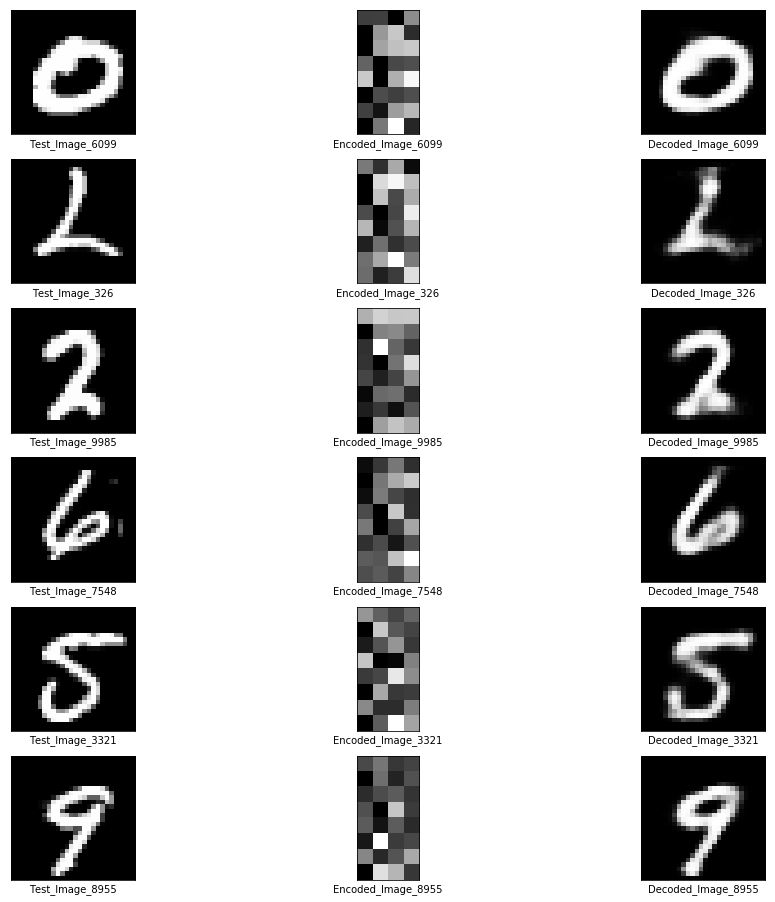

In [17]:
plot_images(6, (16, 16), IMAGE_WIDTH, IMAGE_HEIGHT, encoder, decoder)

In [18]:
encoder.save('./encoder.h5')
decoder.save('./decoder.h5')